In [729]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import os
from osgeo import ogr
import gdal
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
import shapely
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon,shape
from shapely.strtree import STRtree  

# hand made functions
from Rouss1 import get_heads, get_spdis, get_budgetobj

from Chabart_fun import pump_data

In [730]:
model_dir = "working"
model_name = "test_perma"
exe_name= "../../exe/mf6"

In [731]:
#path to data already pre-processed
top_name = "top.npy"
bot_name = "bot.npy"
idom_name = "idomain.npy"

top = np.load(os.path.join(model_dir,top_name))
bot = np.load(os.path.join(model_dir,bot_name))
idomain = np.load(os.path.join(model_dir,idom_name))

In [732]:
# spatial parameters
x0 = 620e3
y0 = 3024e3
nlay = 5
nrow = 38
ncol = 42
delr = np.ones(ncol)*1000
delc = np.ones(nrow)*1000

In [733]:
# recharge
rch_zones = "../data/rch_zone.csv"
rch_data = pd.read_csv(rch_zones,sep=";",header=None,na_values=None)
rch_val = [80,120,120,60,60,50,25,45]

# de la triche
#rch_val *=np.ones(len(rch_val))*1.1 

for i in range(len(rch_val)):
    rch_data[rch_data==i+1]=rch_val[i]
rch_data[rch_data==7777]=0

# separate the recharge by layer
rch_l1 = rch_data[pd.DataFrame(idomain[0]==1)]
rch_l1.fillna(0,inplace=True)
rch_l2 = rch_data[(pd.DataFrame(idomain[0]==0)&(pd.DataFrame(idomain[2]==1)))]
rch_l2.fillna(0,inplace=True)
rch_l3 = rch_data[((pd.DataFrame(idomain[0]==0))&(pd.DataFrame(idomain[2]!=1)))&(pd.DataFrame(idomain[4]==1))]
rch_l3.fillna(0,inplace=True)

In [734]:
#irrig + recharge total
irrig_zon = "../data/zir.csv"
irrig = pd.read_csv(irrig_zon,sep=";",header=None,na_values=None)
irrig[irrig==7777]=0
irr_val = [-110.5,12,3,12,420]
i_val = [9,11,12,15,16]
for i in range(len(irr_val)):
    irrig[irrig==i_val[i]]=irr_val[i]

#combine the two recharge : efficient rain + irrigation
rch_l1 = rch_l1 + irrig

#combine the differents recharges by layer in one 3d list
rch_list = np.zeros([5,nrow,ncol])
rch_list[0] = rch_l1
rch_list[2] = rch_l2
rch_list[4] = rch_l3

# pre-process data in the right format
lst_rch = []
for ilay in np.arange(rch_list.shape[0]):
    for irow in np.arange(rch_list.shape[1]):
        for icol in np.arange(rch_list.shape[2]):
            if rch_list[ilay,irow,icol] != 0:
                rch_cell = ((ilay,irow,icol),rch_list[ilay,irow,icol]/1000/365/86400)
                lst_rch.append(rch_cell)

In [735]:
rch_list.sum()*1000/365/86400

1.9243880010147134

In [736]:
rch_data.sum().sum()*1000/365/86400

2.064466007102993

In [737]:
# drain from the rivers
drain_path = "../data/debordement.csv"
drain_zones = pd.read_csv(drain_path,sep=";",header=None,na_values=None)
drain_zones[drain_zones==7777]=0

cond = 10
lst_drn=[]
for irow in np.arange(nrow):
    for icol in np.arange(ncol):
        if drain_zones.iloc[irow,icol]:
            drain = ((0,irow,icol),top[irow,icol],cond)
            lst_drn.append(drain)       

In [738]:
# constant head sea

sea_chd = []
col = [32,31,31,32,33,34,37,35,36,37,38,39]
row = [0,1,2,3,5,6,7,19,21,23,28,35]
for i in np.arange(len(col)):
    
    if i+1 < len(col):
        for irow in np.arange(row[i],row[i+1]):
            for icol in np.arange(col[i],42):
                chd=(0,irow,icol)
                sea_chd.append((chd,0.1))
    else:
        irow = row[i]
        for icol in np.arange(col[i],42):
            chd=(0,irow,icol)
            sea_chd.append((chd,0.1))
# one remaining
sea_chd.append(((0,7,35),0.1))

In [739]:
# constant head rivers
riv_chd=[((0,16,26),22),((0,16,27),20),((0,15,28),15),((0,15,29),14),((0,15,30),12),((0,15,31),9),
         ((0,22,28),16),((0,22,29),14),((0,23,30),10),
         ((0,30,30),18),((0,30,32),12)
        ]

In [740]:
# constant head pliocene
plio_chd = [((4,2,26),11),((4,8,19),34),((4,10,19),45),((4,11,18),50),((4,14,15),85),((4,14,14),90),
           ((4,22,7),115),((4,22,8),115),((4,24,10),115),((4,24,11),112),((4,25,11),115),((4,25,12),110),((4,26,12),112)]

In [741]:
# pumping
#path
deb_c1 = "../data/prelev_c1.csv"
deb_c2 = "../data/prelev_c2.csv"
deb_c3 = "../data/prelev_c3.csv"

fac = 1000/365/86400
pumpc1 = pump_data(deb_c1,layer=0,fac=fac)
pumpc2 = pump_data(deb_c2,layer=2,fac=fac)
pumpc3 = pump_data(deb_c3,layer=4,fac=fac)

well_data = [];suma=0
for i in [pumpc1,pumpc2,pumpc3]:
    for o in i:
        well_data.append(o)
        suma += o[1]
        
well_data.remove(((4, 3, 21), -2*fac)) # outside of the domain ???

In [742]:
#permeability
perma1 = "../data/perma1.csv"
perma2 = "../data/perma2.csv"
perma3 = "../data/perma3.csv"

KH = np.ones([5,nrow,ncol])

perma_c1 = pd.read_csv(perma1,sep=";",header=None)
perma_c2 = pd.read_csv(perma2,sep=";",header=None)
perma_c3 = pd.read_csv(perma3,sep=";",header=None)

#attribute the value at each layer
KH[0]=perma_c1.values*1e-4 # Quat
KH[1]=0.25e-8 #epontes
KH[2]=perma_c2.values*1e-4 # Salanque
KH[3]=0.25e-8 #epontes
KH[4]=perma_c3.values*1e-4 # Plio

In [743]:
sim = fp.mf6.MFSimulation(sim_name='theis_mf6', version='mf6', exe_name=exe_name, 
                          sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=bot,xorigin=x0,yorigin=y0,idomain=idomain)

tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])
ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity='simple')

# initial conditions
ic   = fp.mf6.ModflowGwfic(gwf)

# nodeflowproperty
npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=[0,0,0,0,0], k=KH, save_flows=True,save_specific_discharge=True)

# recharge
mm = lst_rch
rch  = fp.mf6.ModflowGwfrch(gwf, maxbound=len(mm),fixed_cell=True,pname="rch",
                            stress_period_data = mm,save_flows=True)

# output control
oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            saverecord=[('HEAD', 'LAST'),
                                        ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'LAST'),
                                         ('BUDGET', 'ALL')])

# constant heads
chd = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf,pname="sea",filename="sea.chd",maxbound=len(sea_chd),
                                            stress_period_data={0:sea_chd})
riv = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf,pname="riv",filename="riv.chd",maxbound=len(riv_chd),
                                            stress_period_data={0:riv_chd})
plio = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf,pname="plio",filename="plio.chd",maxbound=len(plio_chd),
                                            stress_period_data={0:plio_chd},save_flows=True)

# well package
wel1 = fp.mf6.modflow.mfgwfwel.ModflowGwfwel(gwf,pname="well",filename="well.wel",maxbound=len(well_data),
                                             stress_period_data={0:well_data},save_flows=True)

#drain package
debordement = fp.mf6.modflow.mfgwfdrn.ModflowGwfdrn(gwf,pname="debordement",filename="debordement.drn",
                                                   maxbound=len(lst_drn),stress_period_data={0:lst_drn}
                                                   ,save_flows=True)

In [744]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model test_perma...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rch...
    writing package oc...
    writing package sea...
    writing package riv...
    writing package plio...
    writing package well...
    writing package debordement...


In [745]:
sim.run_simulation()

FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources Soft

(True, [])

In [746]:
head = get_heads(model_name,model_dir)
spd = get_spdis(model_name,model_dir)

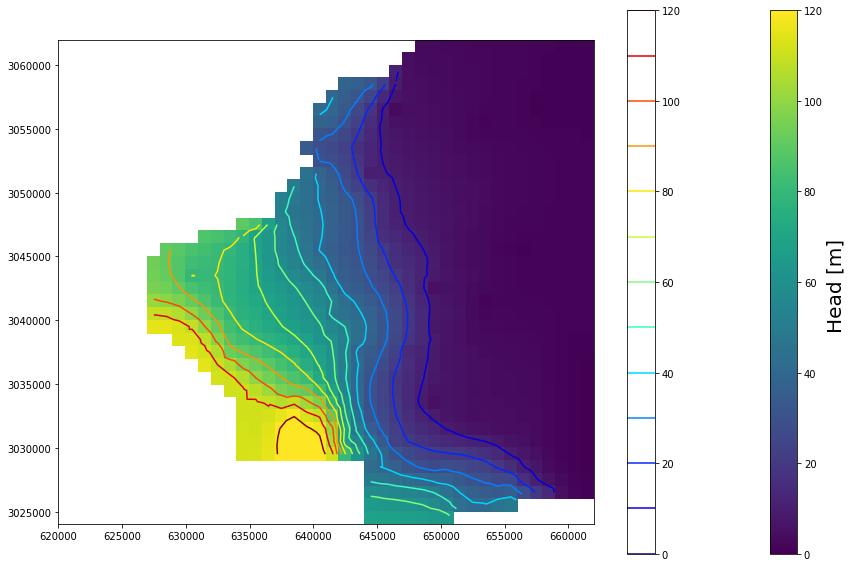

In [760]:
fig = plt.figure(figsize=(15,10))
ax  = plt.subplot(1, 1, 1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf)

#hmesh=ml.plot_ibound()
hmesh=ml.plot_array(head[4],masked_values=[1e30],cmap="viridis")
g1=plt.colorbar(hmesh)
hmesh.set_clim(0,120)
#ml.plot_bc("sea",color="lightblue",alpha=0.5)
#ml.plot_bc("riv",color="lightblue",alpha=0.5)
#ml.plot_bc("debordement",color="red",alpha=0.2)
hmesh=ml.contour_array(head[4],masked_values=[1e30],levels=np.linspace(0,120,13),cmap="jet")
g=plt.colorbar(hmesh)
g1.set_label("Head [m] ",fontsize=20)

In [748]:
spdfile = '{}.cbc'.format(model_name)
fname = os.path.join(model_dir,spdfile)    
spdobj = fp.utils.CellBudgetFile(fname, precision='double') 

In [749]:
spdobj.get_unique_record_names()

[b'    FLOW-JA-FACE',
 b'      DATA-SPDIS',
 b'             WEL',
 b'             DRN',
 b'             RCH',
 b'             CHD']

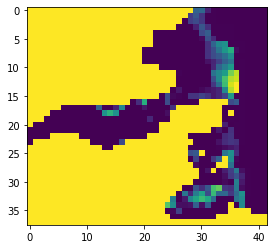

In [761]:
a=plt.imshow(head[0]-top)
a.set_clim(0,20)

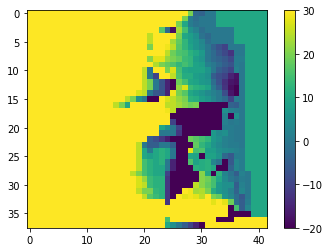

In [762]:
a=plt.imshow(top)
a.set_clim(-20,30)
plt.colorbar()